In [1]:
%matplotlib inline
import numpy as np
from numpy.random import normal
from random import random
import matplotlib.pyplot as plt
import matplotlib as mp
import matplotlib.colors as colors
import math
from brainsignals.plotting_convention import mark_subplots

# plotting aestethics
def adjust_spines(ax, visible_spines):

    ax.label_outer(remove_inner_ticks=True)
    #ax.grid(color='0.9')

    for loc, spine in ax.spines.items():
        if loc in visible_spines:
            spine.set_position(('outward', 10))  # outward by 10 points
        else:
            spine.set_visible(False)

def distribution(N, d, distribution='Uniform'):
    """
    Parameters
    ----------
    N : int
        Number of neurons.
    d : float
        Distribution height.
    distribution : function
        Type of distribution. The default is 'Uniform'.

    Returns
    -------
    z : numpy array
        An array with different z-values.
    """
    if distribution == 'Uniform':
        z = [d*random() - d/2 for i in range(N)]
    elif distribution == 'Normal':
        z = normal(0, d*0.341, N)
    
    return np.array(z)

def get_random_xyz(N, d, r_d):
    z = distribution(N, d, distribution='Normal')
    x = np.zeros(N)
    y = np.zeros(N)

    for i in range(N):
        r_n = r_d*np.sqrt(random())
        theta = random()*2*np.pi
        x[i] = r_n*np.cos(theta)
        y[i] = r_n*np.sin(theta)
    
    return x, y, z # (µm)

def dipole_potential(elec_locs, dipole_pos, p, sigma, lim):
    # Potential in infinite homogeneous medium
    r_ = elec_locs - dipole_pos.T
    r_xyz = np.sqrt(r_.T[0]**2 + r_.T[1]**2 + r_.T[2]**2)
    
    for i, r in enumerate(r_xyz):
        if r < lim:
            r_[i][0] += (lim - r)/r*r_[i][0]
            r_[i][1] += (lim - r)/r*r_[i][1]
            r_[i][2] += (lim - r)/r*r_[i][2]
            # print(r_xyz[i], np.sqrt(r_[i][0]**2 + r_[i][1]**2 + r_[i][2]**2))
    
    V_e =  1. / (4 * np.pi * sigma) * (np.dot(r_, p.T)
              / np.linalg.norm(r_, axis=1) ** 3)
    return V_e

def dipole_plot(elec_locs, dipole_pos, p, sigma, lim):
    # Potential in infinite homogeneous medium
    r_ = elec_locs - dipole_pos.T

    V_e =  1. / (4 * np.pi * sigma) * (np.dot(r_, p.T)
              / np.linalg.norm(r_, axis=1) ** 3)
    return V_e

def get_V_at_z(dipole_loc, z_plot, cdm, sigma, lim):
    V_plot = []
    V_abs = []
    k = None
    for i in z_plot:
        if k != round(list(z_plot).index(i)/len(z_plot),2):
            #print(f'{round(list(z_plot).index(i)/len(z_plot)*100)} %')
            k = round(list(z_plot).index(i)/len(z_plot),2)
        
        r_elecs = np.array([0, 0, i])  # (µm)
        V_p = dipole_potential(r_elecs, dipole_loc, cdm[:, 0], sigma, lim) #
        
        V_plot.append(sum(V_p))
        V_abs.append(abs(sum(V_p)))
    return V_plot, V_abs
    #print(i, round(V_plot[-1]))

def potential_geom(n_sims, radius_array, depth_array, p, measuring_dist):
    rho = 10**(5) # (celler/mmˆ3)
    sigma = 0.276 # (S/m)
    seeg_potentials = []
    n_neurons = []
    potential_at_loc = {}

    for i in radius_array:
        potential_at_loc[i] = {}
        n_neuron = []
        for j in depth_array:
            potential_at_loc[i][j] = []
            n_neuron.append(int(rho*j*10**(-3)*np.pi*(i*10**(-3))**2))
        n_neurons.append(n_neuron)

    for _ in range(n_sims):
        print(_)
        for j, radius in enumerate(radius_array):
            for i, height in enumerate(depth_array):
                N = int(rho*height*10**(-3)*np.pi*(radius*10**(-3))**2)
                dipole_pos = np.array(get_random_xyz(N, height, radius))
                V_SEEG, V_abs = get_V_at_z(dipole_pos, measuring_dist, p, sigma, 50)
            
                potential_at_loc[radius][height].append(V_abs[0])
                #print(f'radius = {round(radius,)} µm | height = {round(height,1)} µm | V = {round(V_SEEG[0],2)} mV | N = {N}')

        print('--------------')
    return potential_at_loc

In [2]:
np.random.seed(123)

n_sims = 10
radius_vals_125 = list(np.arange(700, 1200 + 25, 25))
height_vals_125 = list(np.arange(700, 1200 + 25, 25))
z_plot = [500]

cdm_amp = 125 # (nA µm)
p = np.array([[0.], [0.], [cdm_amp]])  # (nA µm)
seeg_potentials_125 = potential_geom(n_sims, radius_vals_125, height_vals_125, p, z_plot)

n_sims = 10
radius_vals_190 = list(np.arange(300, 800 + 25, 25))
height_vals_190 = list(np.arange(300, 800 + 25, 25))
z_plot = [500]

cdm_amp = 190 # (nA µm)
p = np.array([[0.], [0.], [cdm_amp]])  # (nA µm)
seeg_potentials_190 = potential_geom(n_sims, radius_vals_190, height_vals_190, p, z_plot)

0
--------------
1
--------------
2
--------------
3
--------------
4
--------------
5
--------------
6
--------------
7
--------------
8
--------------
9
--------------
0
--------------
1
--------------
2
--------------
3
--------------
4
--------------
5
--------------
6
--------------
7
--------------
8
--------------
9
--------------


In [3]:
seeg_potentials_125_mean = []
pots_loc = np.zeros(len(radius_vals_125))
neur_loc = np.zeros(len(radius_vals_125))
height_loc = np.zeros(len(radius_vals_125))
radius_loc = np.zeros(len(radius_vals_125))

for idx, i in enumerate(radius_vals_125):
    seeg_pot_row = []
    for jdx, j in enumerate(height_vals_125):
        seeg_pot_row.append(np.mean(seeg_potentials_125[i][j]))
        #if np.mean(seeg_potentials_190[i][j]) < 10:
            #if np.mean(seeg_potentials_190[i][j]) < 10:
                #print(np.mean(seeg_potentials_190[i][j]))
                #pots_loc[idx] = np.mean(seeg_potentials_190[i][j])
                #neur_loc[idx] = 10**5*j*10**(-3)*np.pi*(i*10**(-3))**2
                #height_loc[idx] = j
                #radius_loc[idx] = i
                
        
    seeg_potentials_125_mean.append(seeg_pot_row)
    
seeg_potentials_190_mean = []
pots_loc = np.zeros(len(radius_vals_190))
neur_loc = np.zeros(len(radius_vals_190))
height_loc = np.zeros(len(radius_vals_190))
radius_loc = np.zeros(len(radius_vals_190))

for idx, i in enumerate(radius_vals_190):
    seeg_pot_row = []
    for jdx, j in enumerate(height_vals_190):
        seeg_pot_row.append(np.mean(seeg_potentials_190[i][j]))
        #if np.mean(seeg_potentials_190[i][j]) < 10:
            #if np.mean(seeg_potentials_190[i][j]) < 10:
                #print(np.mean(seeg_potentials_190[i][j]))
                #pots_loc[idx] = np.mean(seeg_potentials_190[i][j])
                #neur_loc[idx] = 10**5*j*10**(-3)*np.pi*(i*10**(-3))**2
                #height_loc[idx] = j
                #radius_loc[idx] = i
                
        
    seeg_potentials_190_mean.append(seeg_pot_row)

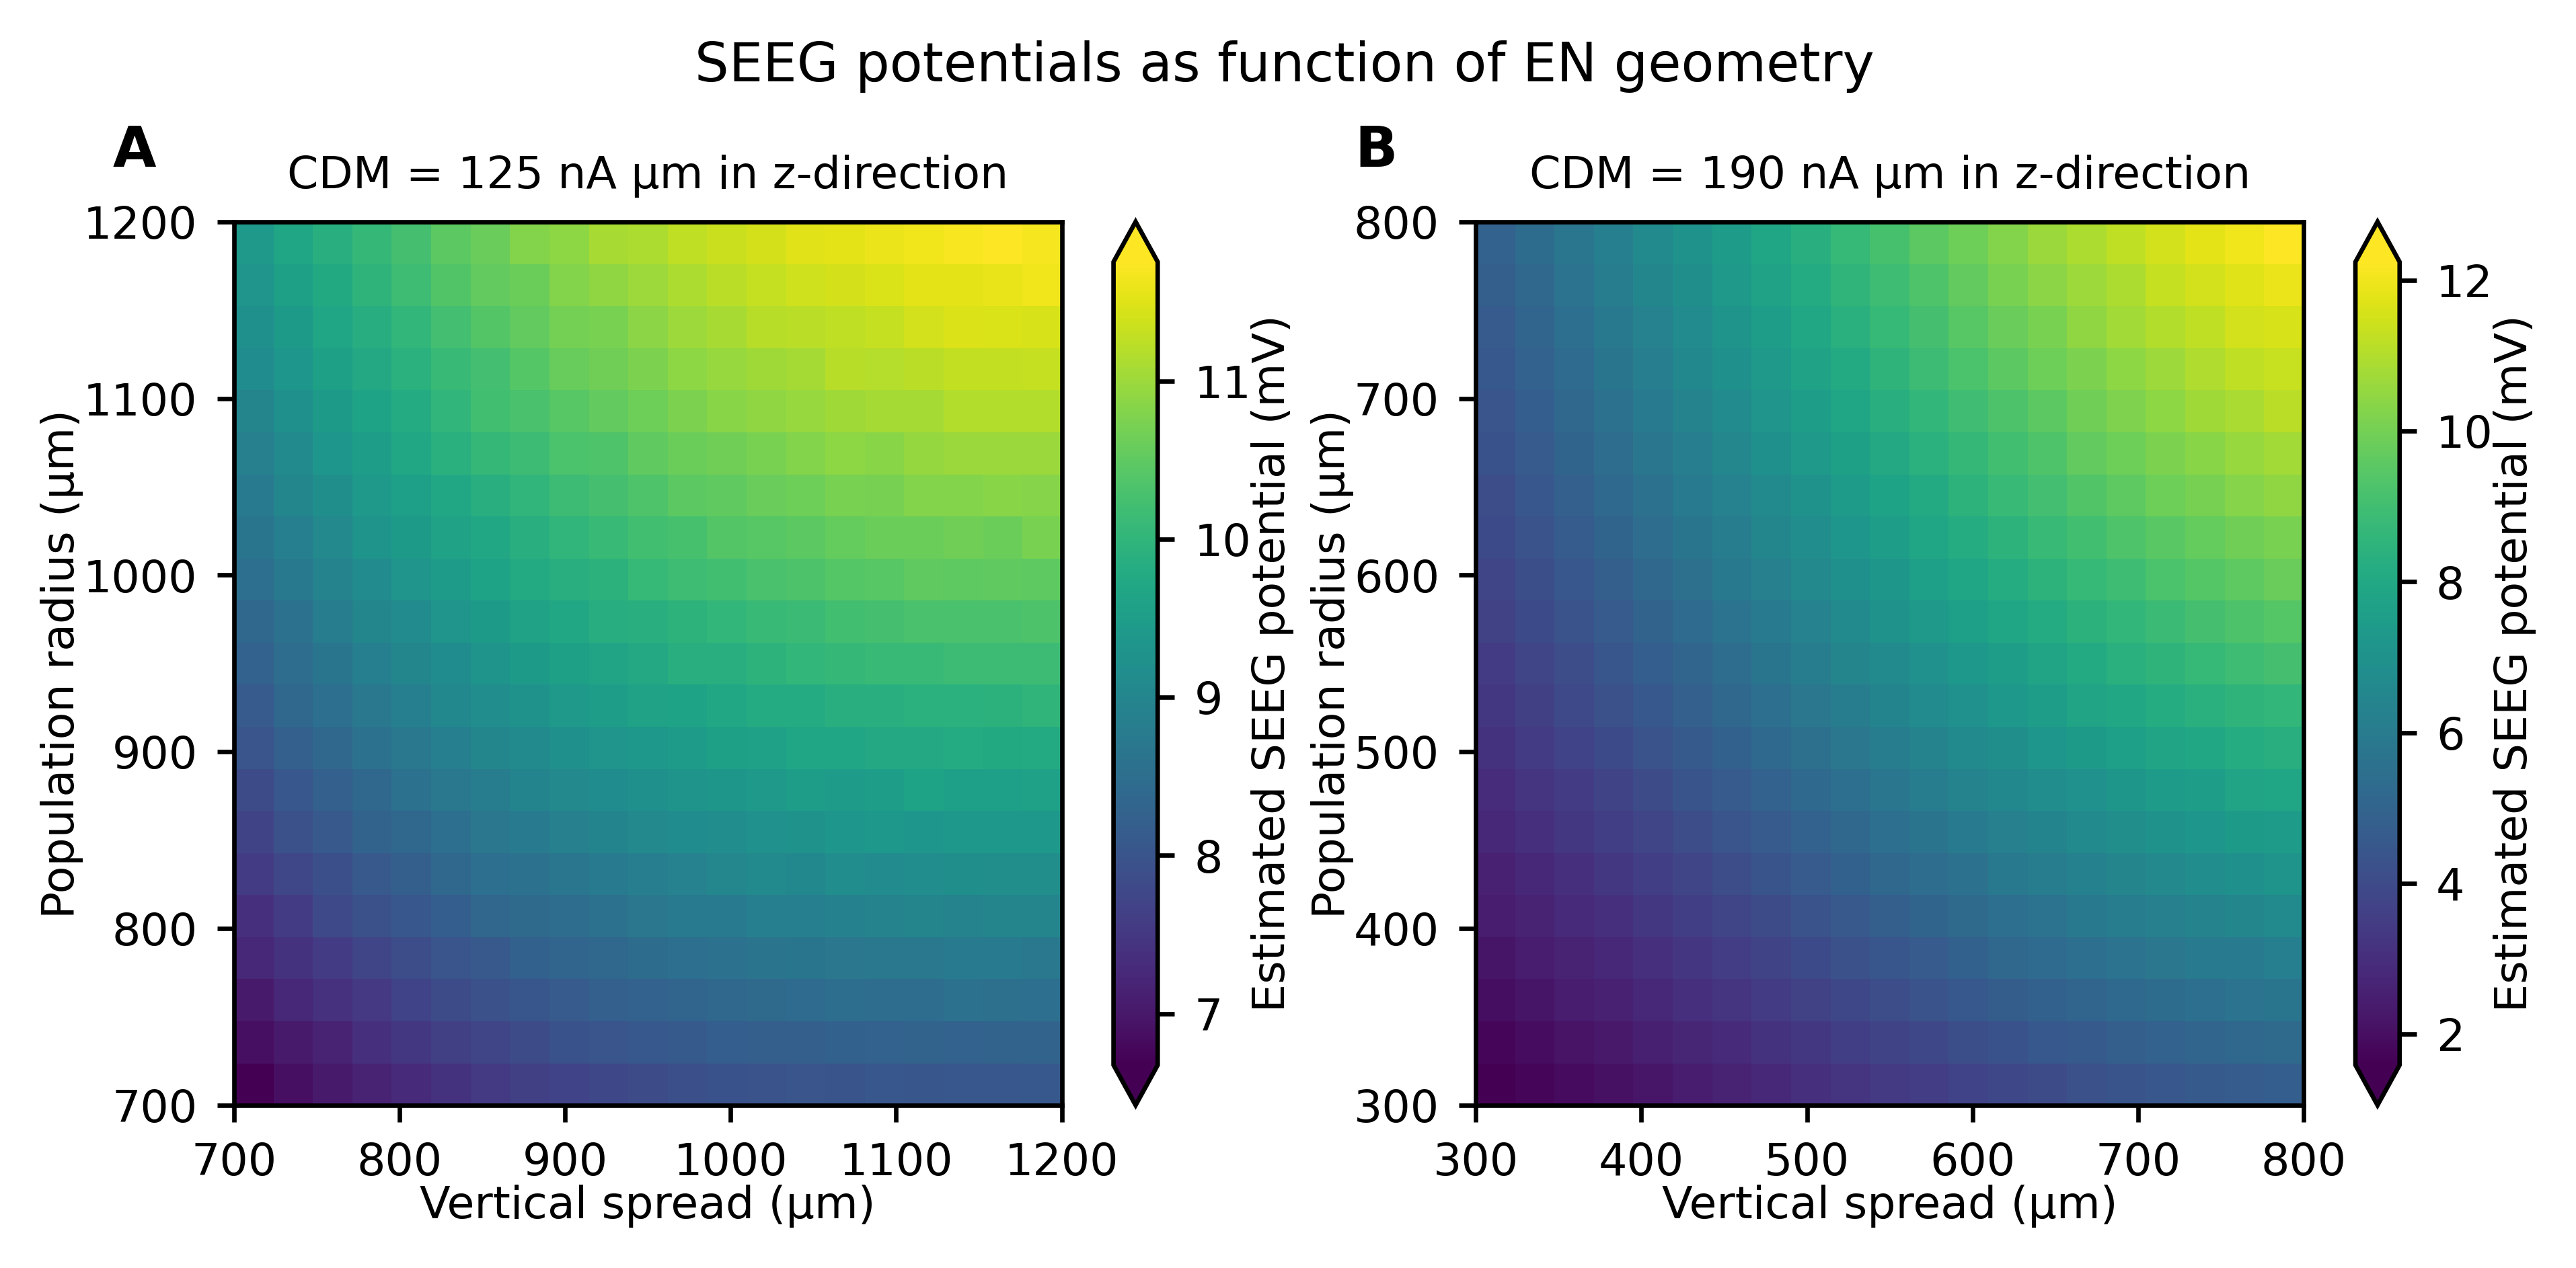

In [6]:
fig = plt.figure(figsize=(6.2,3))

fig.subplots_adjust(bottom=0.1, right=0.99, left=0.08,
                    top=0.83, wspace=.2, hspace=0.35)

im_125 = fig.add_subplot(121, title='CDM = 125 nA µm in z-direction', 
                         xlabel='Vertical spread (µm)', ylabel='Population radius (µm)')
im_190 = fig.add_subplot(122, title='CDM = 190 nA µm in z-direction', 
                         xlabel='Vertical spread (µm)', ylabel='Population radius (µm)')

fig.suptitle('SEEG potentials as function of EN geometry', )
ax1 = im_125.imshow(seeg_potentials_125_mean,
                    origin='lower',
                    cmap='viridis', 
                    extent=[radius_vals_125[0], radius_vals_125[-1], height_vals_125[0], height_vals_125[-1]],
                    aspect='auto') 

# Fargebar
cbar_125 = fig.colorbar(ax1, extend='both', ax=im_125)
cbar_125.set_label('Estimated SEEG potential (mV)')

ax2 = im_190.imshow(seeg_potentials_190_mean, 
                origin='lower',
                cmap='viridis', 
                extent=[radius_vals_190[0], radius_vals_190[-1], height_vals_190[0], height_vals_190[-1]],
                aspect='auto') 

# Fargebar
cbar_190 = fig.colorbar(ax2, extend='both')
cbar_190.set_label('Estimated SEEG potential (mV)')

mark_subplots(im_125, "A", ypos=1.08)
mark_subplots(im_190, "B", ypos=1.08)

plt.savefig('heatmap_SEEG.pdf')